In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
import numpy as np

In [2]:
#models.VGG16_Weights.DEFAULT.transforms()

In [3]:
# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
# Set up directories for the dataset
data_dir = './exotic/'  # Update this path
train_dir = './exotic/train/'
test_dir = './exotic/test/'
val_dir = './exotic/valid/'

In [5]:
# Load the dataset
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

# DataLoader
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False)
}

In [6]:
# Load pre-trained VGG16 model with default weights
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# Freeze the convolutional layers
# for param in model.features.parameters():
#     param.requires_grad = False

# Modify the classifier for the number of classes in your dataset
num_classes = len(image_datasets['train'].classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [7]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [8]:

# Training and validation loop
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Move inputs and labels to the correct device
                inputs, labels = inputs.to(device), labels.to(device)

                # Make sure inputs and model weights have the same type
                # inputs = inputs.type_as(next(model.parameters()))  # Align types
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # # Make sure outputs and labels are on the same device
                    # outputs = outputs.to(device)
                    # labels = labels.to(device)
                    
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects / len(image_datasets[phase])
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    print('Training complete')

# Train the model
train_model(model, criterion, optimizer, num_epochs=1)


Epoch 0/0
----------
train Loss: 1.5404 Acc: 0.6967
test Loss: 0.6051 Acc: 0.8300
Training complete


In [9]:
from PIL import Image
import matplotlib.pyplot as plt


# Function to predict the class of an image
def predict(model, image_path, class_names):
    # Set the model to evaluation mode
    model.eval()

    # Load the image
    image = Image.open(image_path)

    # Define the image transformations (same as training/validation transforms)
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Preprocess the image
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

    # Use GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    input_batch = input_batch.to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(input_batch)
        _, preds = torch.max(outputs, 1)

    # Get the predicted class
    predicted_class = class_names[preds[0]]
    
    # Display the image and the predicted class
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}')
    plt.show()

    return predicted_class




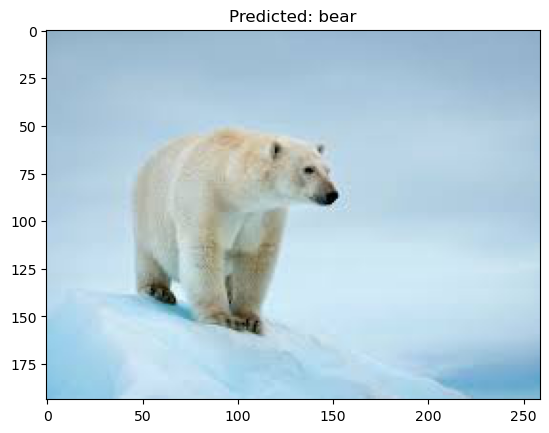

'bear'

In [10]:
# Call Predict functions

classes = image_datasets['train'].classes
predict(model,'polarbear.jpeg',classes)